Exercise 4: Lossy Image Compression
===============================

To complete the exercise, follow the instructions and complete the missing code and write the answers where required.  All points, except the ones marked with **(N points)** are mandatory. The optional tasks require more independet work and some extra effort. Without completing them you can get at most 75 points for the exercise (the total number of points is 100 and results in grade 10). Sometimes there are more optional exercises and you do not have to complete all of them, you can get at most 100 points.

## Introduction

In this exercise, you will implement several concepts from lossy image compression al

of the JPEG pipeline for image compression. The method is based on performing the [discrete cosine transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) on 8x8 blocks, quantizing the resulting coefficients, then losslessly compressing them via entropy encoding. You will first familiarize yourself with the calculation and properties of the DCT by using it on 1D signals, then use its 2D variant to transform and reconstruct images. Finally, you will implement a rough version of the JPEG algorithm and check the reductions in space and quality of the compressed images.

In [1]:
# Run this cell to download the data used in this exercise
import zipfile, urllib.request, io, os
if not os.path.isfile("token"):
    print("Downloading exercise material")
    zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("https://data.vicos.si/lukacu/multimedia/exercise4.zip").read())).extractall()

In [2]:
# Some initial imports

from matplotlib import pyplot as plt
import numpy as np
from skimage import data, io, color

## Assignment 1: Block Truncation Coding

One of the early lossy image compression approaches divides image into 4x4 blocks and encodes each block with a mean, a standard deviation and a binary image that denotes if each of the 16 pixels in the block is higher or lower than the mean value. This approach is called Block Truncation Coding and is in some respects a predecesor to more well known lossy image compression codecs, such as JPEG.

 * Load image `tiger.bmp` (convert it to grayscale) and divide it into 4x4 blocks. Since the image dimensions are not divisible by 4, use `np.pad` to make image bigger. Order blocks row-by-row and visualize blocks 3, 216, and 387 (note that counting starts with 0). Note that you should manually set `vmin` and `vmax` parameters of `imshow` to get a representative visualization.
 
   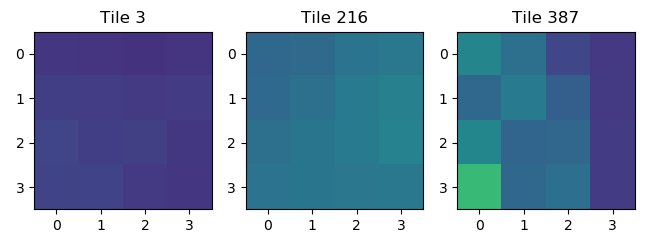

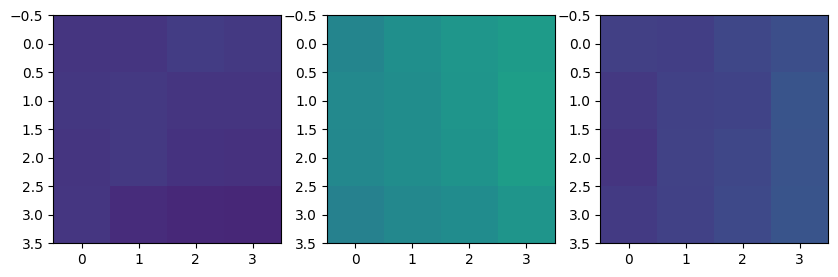

In [6]:
I = color.rgb2gray(io.imread("tiger.bmp")) * 255

def padding(size, block_size):
    """ A helper function to calculate padding size. """
    return int(np.ceil(size / block_size) * block_size - size)

I = np.pad(I, ((0,padding(I.shape[0], 4)), (0,padding(I.shape[1], 4))))

I_blocks = [I[i:i+4, j:j+4] for i in range(0, I.shape[0], 4) for j in range(0, I.shape[1], 4)]
_, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(I_blocks[3], vmin=0, vmax=255)
ax[1].imshow(I_blocks[216], vmin=0, vmax=255)
ax[2].imshow(I_blocks[387], vmin=0, vmax=255)
plt.show()


 * For each block compute the mean value and standard deviation of the values. Then use thresholding to determine which pixels are greater than the mean value. Write function `btc_compress` that accepts a grayscale image and returns a list of tuples containing mean, standard deviation and a list of 16 logical values. 
 
    For the sixth block the output should be `(27, 5, [True, True, True, True, False, True, True, True, False, False, False, True, False, False, False, False])`. Note that one of the problems of not getting the same result could be that you do not use a 8-bit image. If your grayscale image is not 8-bit, scale and round the values to the nearest integer.

In [49]:
def btc_compress(I):
    ret = []
    for i in range(0, I.shape[0], 4):
        for j in range(0, I.shape[1], 4):
            block = I[i:i+4, j:j+4]
            mean = int(np.mean(block))
            std_dev = int(np.std(block))
            bool_values = []
            for k in range(0, 4):
                for l in range(0, 4):
                    bool_values.append(block[k][l] > mean)
            ret.append((mean, std_dev, bool_values))
    return ret




I = np.round(color.rgb2gray(io.imread("tiger.bmp")) * 255).astype(np.uint8)
I = np.pad(I, ((0,padding(I.shape[0], 4)), (0,padding(I.shape[1], 4))))
tokens = btc_compress(I)

print(tokens[5][0], tokens[5][1], tokens[5][2])

27 5 [np.True_, np.True_, np.True_, np.True_, np.False_, np.True_, np.True_, np.True_, np.False_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_]


*  **Discussion question**: what is the compression ratio of the BTC coding? Does it change with the content of the image? What are the advantages and disadvantages of this coding scheme?

 * Objective evaluation of the reconstruction quality is important. One simple way to do it is to compute the mean squared error between the original and reconstructed image. Write a function that computes MSE between individual blocks of the original and reconstructed image. Then compute the MSE of the reconstructed image and compare it to the original image.

In [20]:
def btc_decompress(tokens, shape):
    I = np.zeros(shape, dtype=np.uint8)
    index = 0
    for i in range(0, shape[0], 4):
        for j in range(0, shape[1], 4):
            mean, std_dev, bool_values = tokens[index]
            index += 1
            block = np.array(bool_values).reshape((4,4))
            block = block * std_dev + mean
            I[i:i+4, j:j+4] = block
    return I

def mse(I, I_reconstructed):
    if I.shape != I_reconstructed.shape:
        return -1
    return np.mean((I - I_reconstructed) ** 2)

I_reconstructed = btc_decompress(tokens, I.shape)
mse = mse(I, I_reconstructed)
print(mse)


40.21597656805575


* **Discussion question**: Why does the MSE changes with the content of the image?

 * **(5 points)**: Write function `btc_decompress` that accepts a list of tuples and image shape from the task above and returns a reconstructed image. Check the lecture slides for the reconstruction formulas. At the end, crop the padded pixels from the image. Test compression and decompression on the `tiger.bmp` image. Zoom in on an region to see the difference.
 
   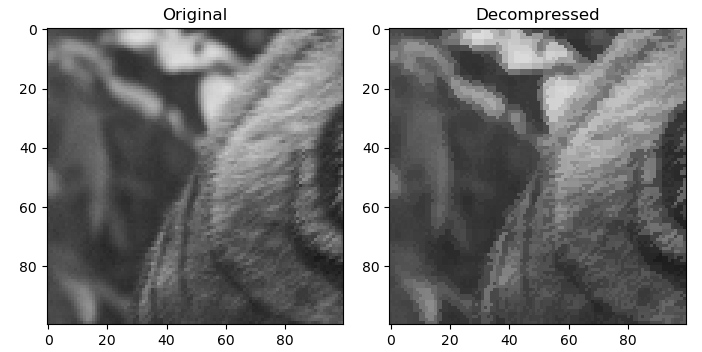

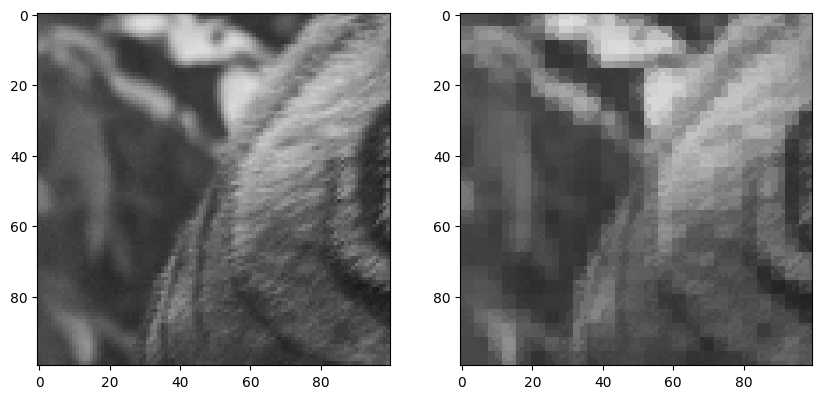

In [25]:
_, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(I[100:200, 100:200], cmap='gray', vmin=0, vmax=255)
ax[1].imshow(I_reconstructed[100:200, 100:200], cmap='gray', vmin=0, vmax=255)
plt.show()

Assignment 2: Discrete Cosine Transform
--------

The discrete cosine transform used in JPEG standard is called DCT-II. The process expresses a (finite) sequence of data points as a sum of cosines with different frequencies (called basis functions). The result is a list of coefficients which can be used to reconstruct the original data. The most commonly used is DCT-II, also called "the DCT". Its inverse, DCT-III is called "the inverse DCT". Their formulas are as follows:

\begin{equation}
X_k = \sum_{n=0}^{N-1}x_n \cos{\Big(\frac{\pi}{N}\Big(n+\frac{1}{2}\Big)k\Big)}; \quad k = 0,\dots, N-1,\\
x_k = \frac{1}{N}X_0+\sum_{n=1}^{N-1}\frac{2}{N} \ X_n \cos{\Big(  \frac{\pi}{N}\ n\ \Big(  k+\frac{1}{2}  \Big)  \Big)}; \quad k = 0,\dots, N-1
\end{equation}

where $x_n$ denotes the $n$-th element of the input signal, while $N$ denotes the total number of elements of the input signal.



 * In DCT, the signal is expressed as a sum of cosines with different frequencies. Consider the length of sequence `N = 10` and plot the basis functions for sequences of this length. The number of basis functions must equal the number of data points (N). To make the plot look smoother you can tabulate the cosine function more accurately by adding more values, e.g. use `200` values instead `10` that are sufficient for computation of DCT. The result should look like this:

    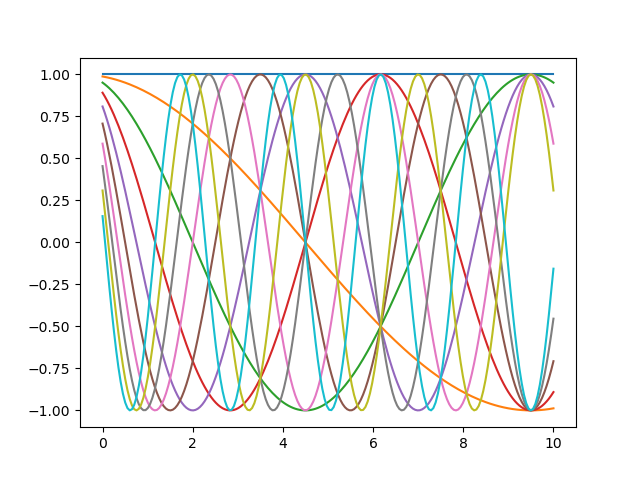

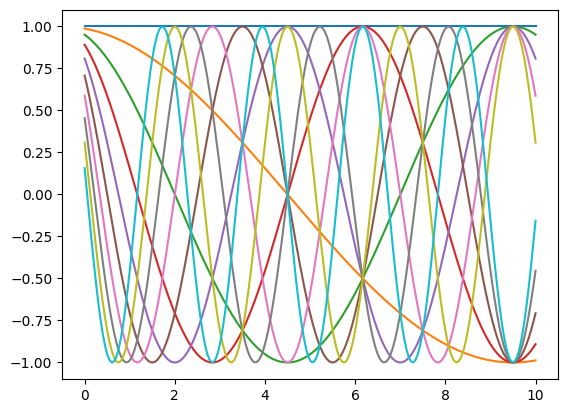

In [ ]:
# Some initial imports

from matplotlib import pyplot as plt
import numpy as np
from skimage import data, io, color

N = 10

_, ax = plt.subplots()

for i in range(N):
    n = np.linpace(0, N, 200)
    y = np.cos(np.pi/N * (n+0.5) * i)
    ax.plot(n, y)
plt.show()


 * Implement 1D DCT transform and its inverse. Implement the ``my_dct`` and ``my_idct`` functions that receive a signal and return the DCT coefficients (the sizes must match). Use the above formulas. Take note that these are the basic formulas. In practice, scaling factors are used to allow the transform to be expressed as matrix multiplication (see point <i>(d)</i>). You can test the correctness of your implementation by transforming a signal to frequency domain and back again. The result should be equal to the input signal (up to machine precision).

In [42]:
def my_dct(input_signal):
    N = len(input_signal)
    ret = np.array([np.sum(input_signal * np.cos(np.pi/N * (np.arange(0, N) + 0.5) * k)) for k in range(N)])
    return ret


In [41]:
def my_idct(input_signal):
    N = len(input_signal)
    ret = np.array([input_signal[0] / N + np.sum(2/N * input_signal[1:] * np.cos(np.pi/N * np.arange(1, N) * (k + 0.5))) for k in range(N)])
    return ret

 * Visualize the signal reconstruction from the DCT coefficients. Perform the DCT (using `my_dct`) on a chosen signal (to make the process easier to follow, start with `y = np.sin(np.exp(x) * 0.2)`), then transform it back using `my_idct`. Plot the intermediate result. If performed correctly, the signal should in the end be fully reconstructed. Also plot the error between the original and the reconstuction.

    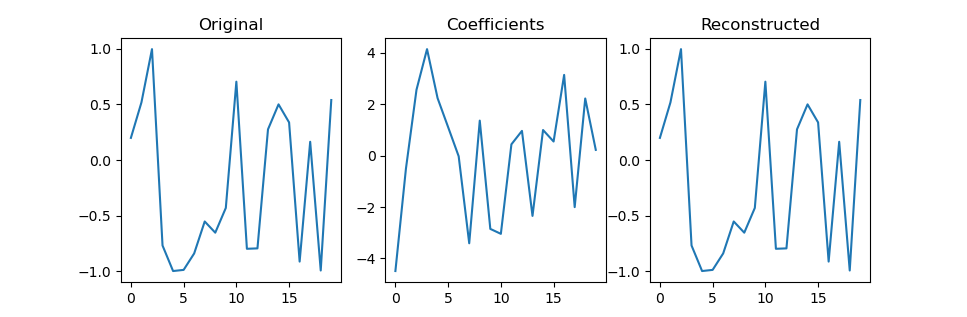

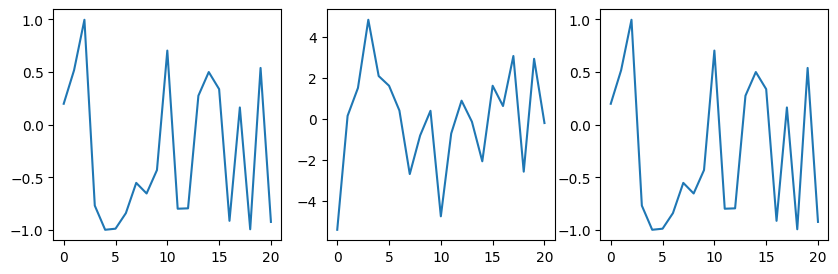

In [51]:
x = np.linspace(0, 20, 21)
y = np.sin(np.exp(x) * 0.2)

dct = my_dct(y)
idct = my_idct(dct)

_, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].plot(y)
ax[1].plot(dct)
ax[2].plot(idct)
plt.show()

 * **(5 points)** The first term ($X_0$) of the DCT is sometimes multiplied by $\frac{1}{\sqrt{2}}$ and the resulting matrix is multiplied by an overall scale factor of $\sqrt{\frac{2}{N}}$. This makes the matrix orthogonal and allows the DCT (and the IDCT) to be performed by matrix multiplication. Write a ``dct_coef`` function that takes a size $N$ and returns a $N\times N$ matrix with the DCT coefficients. If the matrix is scaled correctly it should be orthogonal (i.e. $\mathbf{M}\mathbf{M}^\top=\mathbf{I}$). You can check the implementation details for scaling on <a href="https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II">Wikipedia</a>. The DCT can then be calculated by multiplying a signal $x$ by the DCT coefficient matrix $\mathbf{M}$. The same holds for the IDCT, except that it requires multiplication by the transpose of the matrix $\mathbf{M}$.

    $$
    y = \mathbf{M}x^\top \\
    \hat{x} = (\mathbf{M}^\top y)^\top
    $$

    Using ``dct_coef`` write alternate implementations of ``my_dct`` and ``dct_idct`` and test if they work.

In [11]:
# TODO: write the code here
raise NotImplementedError()

 * The DCT on two-dimensional data can be performed either by first calculating the 1D DCT on matrix rows and then on matrix columns (or vice versa) or by applying the formula directly.

    $$
    X_{i,j} = C_{i} C_{j} \sum_{x=0}^{X-1} \sum_{y=0}^{Y-1} x_{x,y} \cos{\bigg(  \frac{\pi}{X} \Big( x + \frac{1}{2} \Big) i \bigg)} \cos{\bigg(  \frac{\pi}{Y} \Big( y + \frac{1}{2} \Big) j \bigg) \quad i= 0,\dots, X-1 \quad j = 0,\dots, Y-1\\}
    $$

    where $x_{x, y}$ denotes the element at $y$-th row and $x$-th column of the input matrix, while $X$ and $Y$ denote the number of rows and the number of columns of the input matrix, respectively. The $C_{i}$ is defined as step function $C_{i} = \sqrt{\frac{1}{X}}$ if $i = 0$ and $C_{i} = \sqrt{\frac{2}{X}}$ otherwise. $C_{j}$ is defined similarly for $j$ and $Y$.

    The inverse of DCT is defined similarly as:

    $$
    x_{x, y}=\sum _{i=0}^{X-1}\sum _{j=0}^{Y-1}  C_{i} C_{j} X_{i, j} \cos \left[{\frac {\pi }{X}}\left(x+{\frac {1}{2}}\right)i\right]\cos \left[{\frac {\pi }{Y}}\left(y+{\frac {1}{2}}\right)j\right]
    $$

     Plot the 2D basis functions. The result should look like this:

    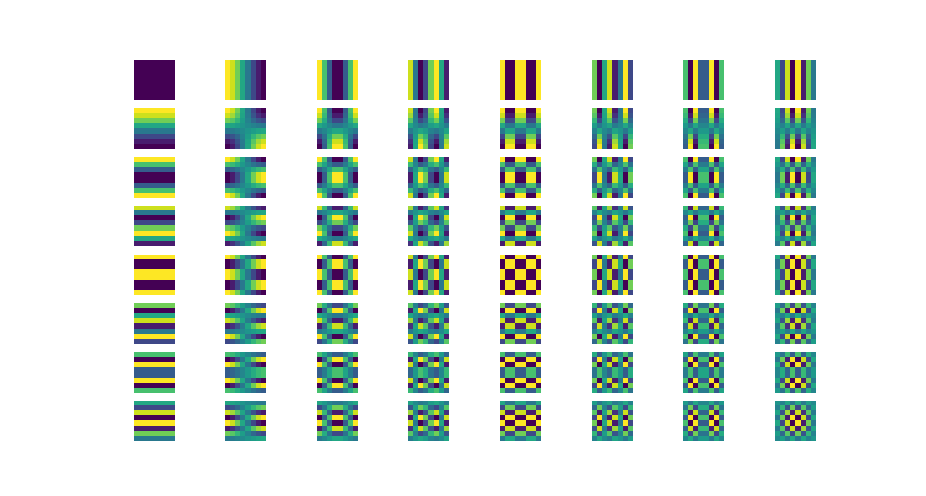


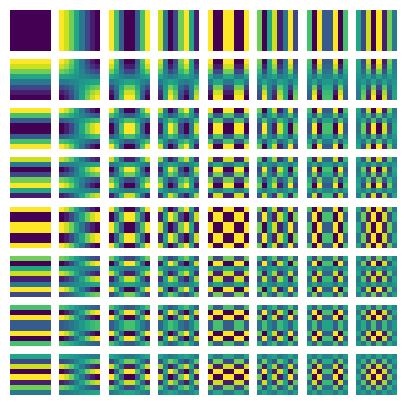

In [61]:
def basis_fun_2d(x, y, i, j, X, Y):
    Ci = 0
    if i == 0:
        Ci = np.sqrt(1/X)
    else:
        Ci = np.sqrt(2/X)
    Cj = 0
    if i == 0:
        Cj = np.sqrt(1/X)
    else:
        Cj = np.sqrt(2/X)
    
    return Ci * Cj * np.cos(np.pi/X * (x + 0.5) * i) * np.cos(np.pi/Y * (y + 0.5) * j)

X = 8
Y = 8
_, ax = plt.subplots(X, Y, figsize=(5,5))
for i in range(X):
    for j in range(Y):
        x = np.linspace(0, X-1, X)
        y = np.linspace(0, Y-1, Y)
        X_val, Y_val = np.meshgrid(x, y) 
        ax[i, j].imshow(np.transpose(basis_fun_2d(X_val, Y_val, i, j, X, Y)))
        ax[i, j].axis('off')


 * Implement the ``my_dct2`` and ``my_idct2`` functions that perform the DCT and IDCT on 2D matrices. Do not use `dct` and `idct` from `scipy.fft`, but you can use those functons to check if your implementation is correct. Test the correctness of your implementation by transforming a signal to frequency domain and back again. The result should be equal to the input signal (up to machine precision).

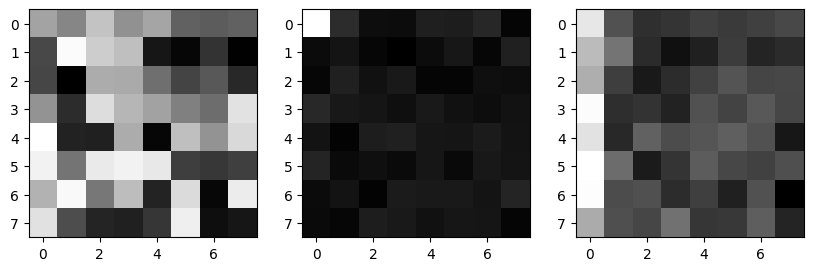

In [64]:
from scipy.fft import dct

def my_dct2(input_signal):
    return np.apply_along_axis(my_dct, 0, np.apply_along_axis(my_dct, 1, input_signal))

signal = np.random.rand(8, 8)
signal_dct = my_dct2(signal)
signal_scipy_dct = dct(signal)

_, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(signal, cmap='gray')
ax[1].imshow(signal_dct, cmap='gray')
ax[2].imshow(signal_scipy_dct, cmap='gray')
plt.show()

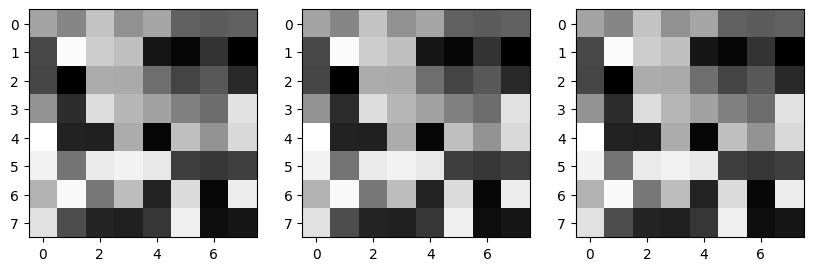

In [65]:
from scipy.fft import idct

def my_idct2(input_signal):
    return np.apply_along_axis(my_idct, 0, np.apply_along_axis(my_idct, 1, input_signal))

signal_idct = my_idct2(signal_dct)
signal_scipy_idct = idct(signal_scipy_dct)

_, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(signal, cmap='gray')
ax[1].imshow(signal_idct, cmap='gray')
ax[2].imshow(signal_scipy_idct, cmap='gray')
plt.show()

 * Reconstruct an image from 2D DCT coefficients. Open a grayscale image (e.g. image *A.bmp*) and calculate its 2D DCT using `my_dct2`. Visualize the coefficient matrix. Convert the image back using `my_idct2`.

    Comment on the contribution of lower and higher frequency components to the reconstruction of the image. Which frequencies are more important perceptually? Slightly modify several coefficients to see the effect.

    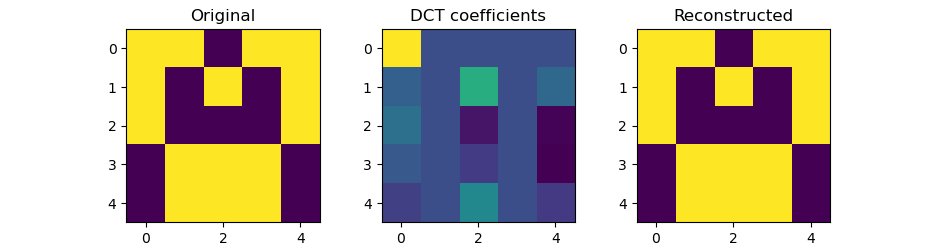

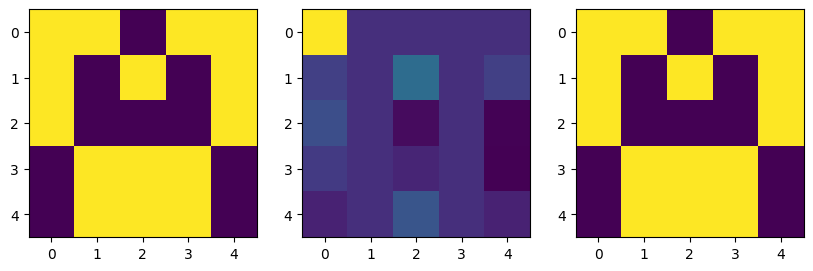

In [ ]:
A = io.imread("A.bmp")

A_dct = my_dct2(A)
A_reconstructed = my_idct2(A_dct)

_, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(A)
ax[1].imshow(A_dct)
ax[2].imshow(A_reconstructed)
plt.show()

# Lower frequencies are more important, as higher frequencies only show us detail

* Load one of the images from one of the previous exercises, convert it to grayscale. Then cut out several square blocks of 24x24 pixels and perform encoding/decoding using DCT. Test, how is the content modified if you modify the entire DCT coefficent matrix, and how if you modify the three quarters that denote the high frequency coefficients (all except top-left quarter). Apply the quantization formula:

    $$
    \hat{X}_{i,j} =  \Biggl \lfloor \frac{X_{i,j}}{Q_{i,j}} \Biggr \rfloor Q_{i,j}
    $$

    This task is complete if you do this for five different blocks (try to find different blocks, uniform region, edges, etc.) and visualize (1) original block, (2) DCT coefficients, (3) reconstruction with quantized DCT coefficients, (4) reconstruction with quantized high-frequency components and (5) error between the original and the reconstruction. The result should look like this (quantization factor is 32 for high frequencies and 1 for low frequencies):

    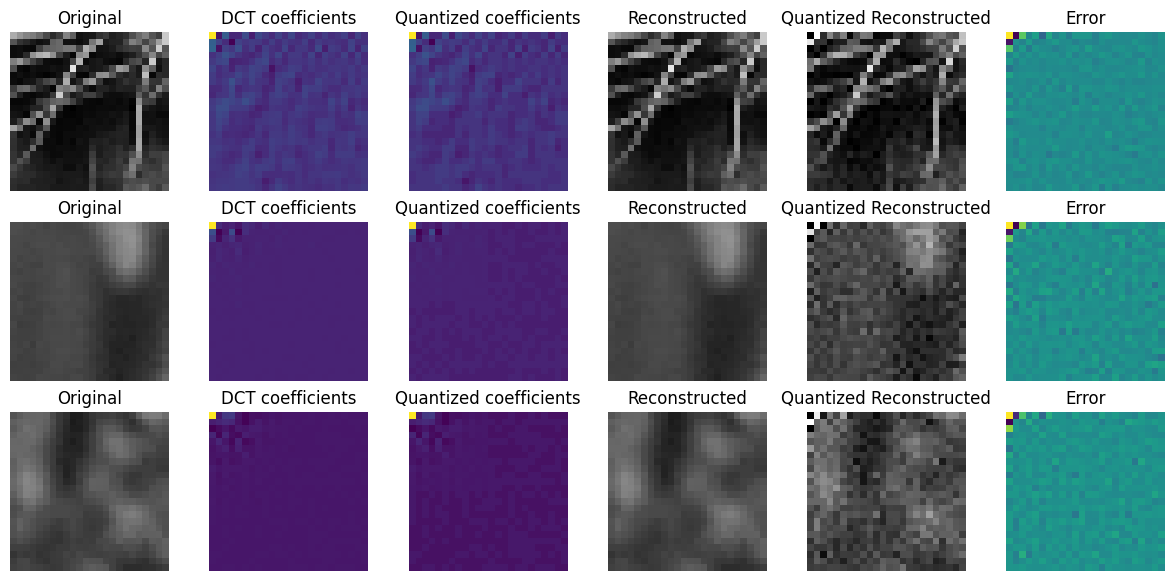

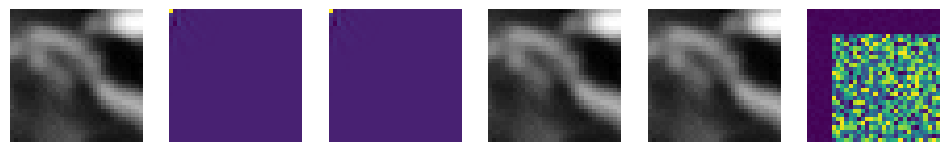

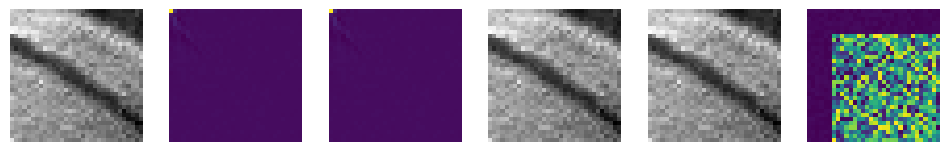

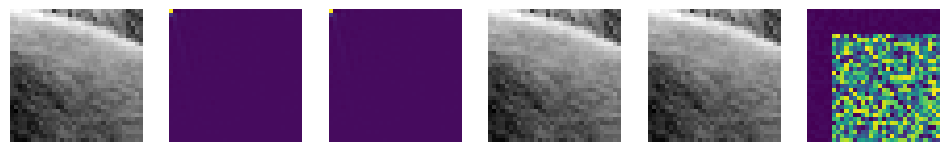

In [72]:
I = color.rgb2gray(io.imread("tiger.bmp")) * 255

Q = np.ones((32,32))
Q[6:, 6:]= 32

blocks = [(100,100), (200,200), (300,300)]

for block in blocks:
    x, y = block
    Original = I[x:x+32, y:y+32]
    Dct = my_dct2(Original)
    Quantized = np.round(Dct / Q) * Q
    Reconstructed = my_idct2(Dct)
    Quantized_reconstructed = my_idct2(Quantized)
    Error = np.abs(Dct - Quantized)

    _, ax = plt.subplots(1,6, figsize=(12,3))
    ax[0].imshow(Original, cmap='gray')
    ax[1].imshow(Dct)
    ax[2].imshow(Quantized)
    ax[3].imshow(Reconstructed, cmap='gray')
    ax[4].imshow(Quantized_reconstructed, cmap='gray')
    ax[5].imshow(Error)
    for i in range(6):
        ax[i].axis('off')
    plt.show()

## Assignment 3: The JPEG Pipeline

In this assignment you will implement the main part of the JPEG compression algorithm. The image needs to be split into $8 \times8$ blocks and DCT must be performed on each of them. The coefficients are then quantized using a quantization matrix. The result is finally losslessly compressed using entropy encoding.

Use the provided ```quantization_matrix``` function to generate different quantization matrices. The function accepts an argument on the interval $[1,100]$ which can be interpreted as the output image quality in percentages. How does the matrix change with different inputs? Experiment with a few values.

In [73]:
# Generation of different quality quantization matrices, based on detail level
def quantization_matrix(alpha_image_quality):    
    
    # For this example we use the standard quantization matrix proposed by the Independent JPEG Group (IJG)
    Q = np.array([[16,  11,  10,  16,  24,  40,  51,  61],
                  [12,  12,  14,  19,  26,  58,  60,  55],
                  [14,  13,  16,  24,  40,  57,  69,  56],
                  [14,  17,  22,  29,  51,  87,  80,  62],
                  [18,  22,  37,  56,  68, 109, 103,  77],
                  [24,  35,  55,  64,  81, 104, 113,  92],
                  [49,  64,  78,  87, 103, 121, 120, 101],
                  [72,  92,  95,  98, 112, 100, 103,  99]])
    
    if(alpha_image_quality < 50):
        s = 5000 / alpha_image_quality
    else:
        s = 200 - 2 * alpha_image_quality
    
    R = np.floor( (s * Q + 50) / 100 )
    R[R == 0] = 1
    
    return R

 * Split your input image into $8\times8$ blocks.

    For each of the blocks, do:
     1. Subtract $128$ (take care of the data type, do not use uint8 here)
     2. Calculate the 2D DCT
     * Perform element-wise division by the quantization matrix $Q$
     * Round the coefficients to quantize them
     * Do element-wise multiplication with $Q$.
     * Save the quantized coefficients in a separate matrix
     * Calculate the 2D IDCT
     * Add $128$

  Display the image reconstructed from quantized blocks. Display the difference to the original. Comment on the distribution of the differences and the reduction in image quality (try different levels of quantization).

  Use the image *tiger.bmp* to test your algorithm.

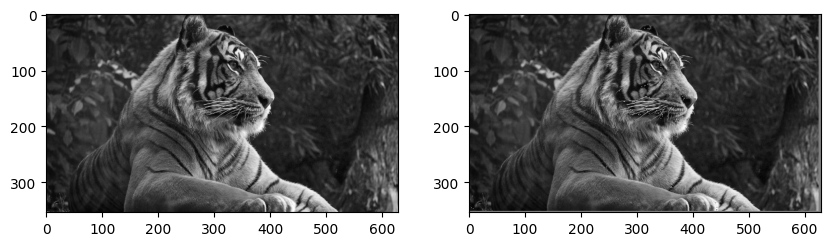

In [82]:
I = io.imread('tiger.bmp')
I = np.mean(I, 2).astype(np.uint8)

window = 8
Q = quantization_matrix(50)
result = np.zeros([I.shape[0], I.shape[1]])

for row in np.arange(I.shape[0] - window + 1, step=window):
    for col in np.arange(I.shape[1] - window + 1, step=window):
        block = I[row:row+window, col:col+window]
        block = block - 128
        block = my_dct2(block)
        block = block / Q
        block = np.round(block)
        block = block * Q
        result[row:row+window, col:col+window] = my_idct2(block)

adjusted = result + 128

_, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(I.astype(np.uint8), cmap='gray')
ax[1].imshow(adjusted.astype(np.uint8), cmap='gray')
plt.show()

        
#the lower the quantization the more artifacts appear

 * **(5 points)** Convert the image into YCbCr color space (e.g. using `skimage.color.rgb2ycbcr`), then subsample the color channels. Then reverse the process and reconstruct the image. Find representative images from previous exercises and comment on the difference using different factors of subsampling. Do the same with the $Y$ channel and comment on the differences. Save some examples images.

In [ ]:
# TODO: Write code here
raise NotImplementedError()

 * **(5 points)** Modify the code to compress the entire matrix of quantized coefficients as it was discussed at the lectures to a byte stream. Comment on the compression ratio for different levels of quantization. 

   **Discussion question:** Why can quantized images be stored using less bits?

In [ ]:
# TODO: Write code here
raise NotImplementedError()

 * **(5 points)** Evaluation of the reconstruction quality for image and video compression goes beyond MSE. Compare BTC and your simple JPEG compression using PNSR and SSIM measures (implemented in `skimage.metrics` package). Use the `tiger.bmp` image as a reference. Discuss the results.

In [ ]:
# TODO: Write code here
raise NotImplementedError()